<a href="https://colab.research.google.com/github/20007213/final-project/blob/main/%E2%80%9Cfinal_work_ml_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deep Convolutional Generative Adversarial Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

### Setup

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.8.2'

In [4]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-88gbd9g3
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-88gbd9g3
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184182 sha256=a37f343808112b7f22be8743dc7259a9f3f8b64de5f944b500a7b10e4330f915
  Stored in directory: /tmp/pip-ephem-wheel-cache-j9ojmnse/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (1, 1), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Use the (as yet untrained) generator to create an image.

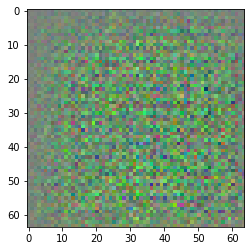

In [8]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0]*100+0.5))

In [ ]:
np.min(generated_image)

-0.015100624

### The Discriminator

The discriminator is a CNN-based image classifier.

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(8, (1, 1), strides=(1, 1), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2)) # 64, 64, 16
    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2)) # 64, 64, 16

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2)) # 32, 32, 32
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2)) # 64, 64, 16

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2)) # 16, 16, 64
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2)) # 16, 16, 64

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2)) # 8, 8, 128
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2)) # 8, 8, 128

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2)) # 4, 4, 128
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2)) # 4, 4, 128


    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[7.5785e-06]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [6]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [7]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [15]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [8]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [9]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [10]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10, 10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i]*0.5 + 0.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

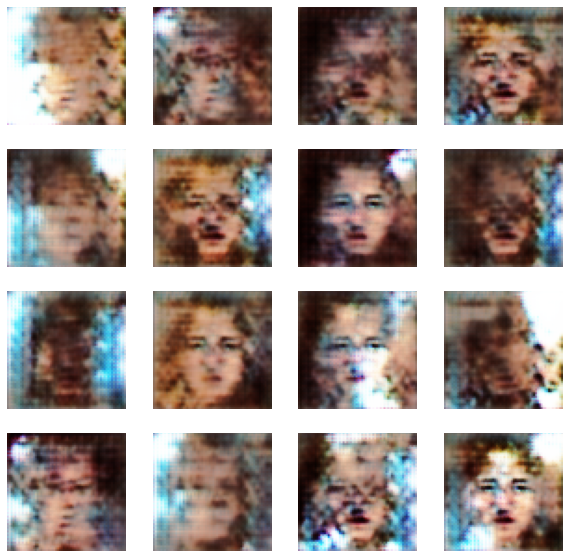

Time for epoch 409 is 11.66037654876709 sec


KeyboardInterrupt: ignored

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
!cp -av /content/training_checkpoints /content/drive/MyDrive

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint('/content/training_checkpoints/ckpt-8.data-00000-of-00001'))

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs see the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).


In [11]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.8.2
TF Hub version:  0.12.0
Eager mode enabled:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [37]:
generator_2 = make_generator_model()
discriminator_2 = make_discriminator_model()

In [56]:
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt-8")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_2,
                                 discriminator=discriminator_2)

In [57]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

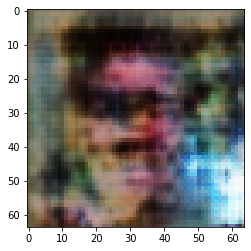

In [58]:


noise = tf.random.normal([1, 100])
generated_image = generator_2(noise, training=False)

plt.imshow((generated_image[0]*0.5+0.5))

In [59]:
# Load TF Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [158]:
!mkdir batch

In [156]:
!rm -r /content/batch

In [163]:
noise_1 = tf.random.normal([1, 100],seed=5)
noise_2 = tf.random.normal([1, 100],seed=6)

# noise_1 = -tf.ones((1,100))
# noise_2 = tf.ones((1,100))

steps=200
latent = []

for i in range(800, 800+steps):
  n = noise_2 * i/steps + noise_1 *(1-i/steps)
  latent.append(n)

  generated_image = generator_2(n, training=False)

  plt.figure(figsize=(10,10))
  plt.axis('off')
  plt.imshow(generated_image[0]*0.5+0.5)
  plt.savefig(f'/content/batch/{i:04}.jpg')
  plt.close()


In [155]:
!ffmpeg -framerate 10 -i /content/batch/%04d.jpg /content/output.mp4

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [85]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tensorflow.keras import layers
import time

from IPython import display

In [115]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[0], shape[1])
  offset_y = max(shape[0] - shape[1], 0) // 2
  offset_x = max(shape[1] - shape[0], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  # image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  # img = tf.io.decode_image(
  #     tf.io.read_file(image_path),
  #     channels=3, dtype=tf.float32)[tf.newaxis, ...]
  
  img = np.array(Image.open(image_url).convert('RGB'))


  img = crop_center(img)
  print(img.shape)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  print(img.shape)
  return img






TF Version:  2.8.2
TF Hub version:  0.12.0
Eager mode enabled:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:


img = np.array(Image.open('/content/drive/MyDrive/thumbnails128x128/00000/00200.png').convert('RGB'))/255
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.savefig(f'/content/f.jpg')

In [107]:
img = np.array(Image.open('/content/phone.png').convert('RGB'))/255

In [133]:
content_image = load_image('/content/phone.png', image_size=(800,800))/255
content_image = np.expand_dims(content_image,axis=0)

content_image.shape

(1720, 1720, 3)
(800, 800, 3)


(1, 800, 800, 3)

In [149]:
sty = load_image('/content/batch/0002.jpg', image_size=(256,256))/255
sty = np.expand_dims(sty,axis=0)

sty.shape

(1, 256, 256, 3)

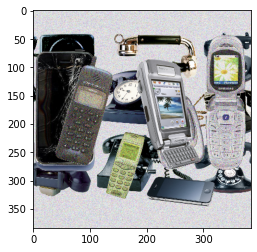

In [120]:
plt.imshow(content_image[0])

In [150]:
outputs = hub_module(tf.constant(sty),tf.constant(content_image))

In [ ]:
generated_image = generator_2(noise, training=False)

plt.imshow((generated_image[0]*0.5+0.5))

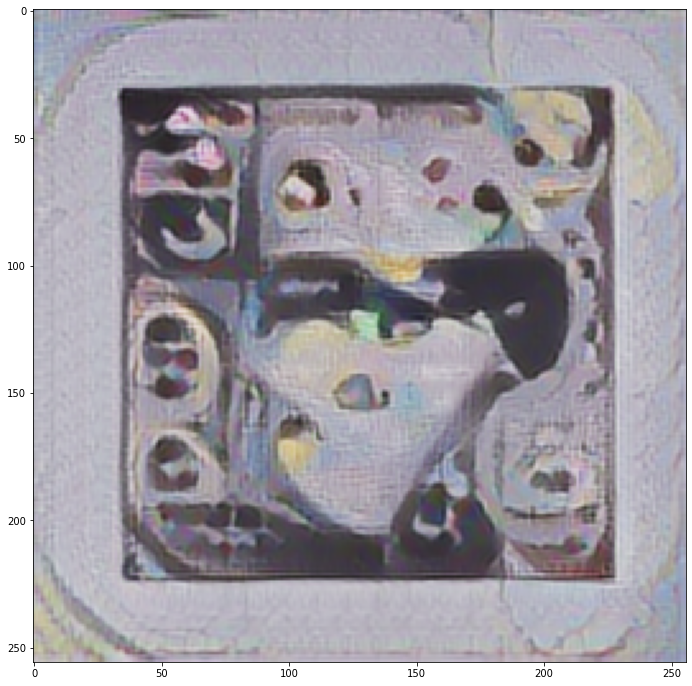

In [151]:
plt.figure(figsize=(12,12))
plt.imshow(outputs[0][0])

In [167]:
!rm -r sty

In [168]:
!mkdir sty

In [169]:

latent = []
content_image = load_image('/content/phone.png', image_size=(800,800))/255
content_image = np.expand_dims(content_image,axis=0)

for i in range(1000):
  sty = load_image(f'/content/batch/{i:04}.jpg', image_size=(256,256))/255
  sty = np.expand_dims(sty,axis=0)

  outputs = hub_module(tf.constant(sty),tf.constant(content_image))

  plt.figure(figsize=(12,12))
  plt.axis('off')
  plt.imshow(outputs[0][0])
  plt.savefig(f'/content/sty/{i:04}.jpg')
  plt.close()


(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 256, 3)
(720, 720, 3)
(256, 

In [172]:
!cp /content/output.mp4 /content/drive/MyDrive

In [171]:
!ffmpeg -framerate 24 -i /content/sty/%04d.jpg /content/output.mp4

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [170]:
1000/24

41.666666666666664